In [1]:
import random
import numpy as np
import torch
import talib
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:


class LSTMTrader:
    def __init__(self, data_path, sequence_length=60, train_split=0.8):
        """
        Initialize the LSTMTrader class.

        Parameters:
        - data_path (str): Path to the CSV file containing the data.
        - sequence_length (int): Number of past observations to use for predicting the next value.
        - train_split (float): Proportion of data to use for training.
        """
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.train_split = train_split

        self.scaler = None  # Initialize scaler as None
        self.model = None
        self.train_losses = []
        self.val_losses = []
        self.strategy_returns = []

        # Data placeholders
        self.data = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.predictions = None
        self.y_test_unscaled = None
        self.backtest_data = None

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def load_data(self):
        """Load and preprocess the data from the CSV file."""
        # Load data
        self.data = pd.read_csv(self.data_path)
        # Use only 'Timestamp' and 'Close' columns
        self.data = self.data[['Timestamp', 'Close']]
        self.data.set_index('Timestamp', inplace=True)
        print("Data loaded successfully.")

    def preprocess_data(self):
        """Scale the data and create training, validation, and testing datasets."""
        # Check if the scaler is already fitted
        if not hasattr(self.scaler, 'min_'):
            # Fit the scaler
            self.scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = self.scaler.fit_transform(self.data)
        else:
            # Use the already fitted scaler
            scaled_data = self.scaler.transform(self.data)

        # Create sequences
        X = []
        y = []
        for i in range(self.sequence_length, len(scaled_data)):
            X.append(scaled_data[i - self.sequence_length:i, 0])
            y.append(scaled_data[i, 0])

        X = np.array(X)
        y = np.array(y)

        # Split into training, validation, and testing sets
        total_length = len(X)
        train_size = int(self.train_split * total_length)
        val_size = int(0.1 * total_length)  # 10% for validation
        test_size = total_length - train_size - val_size

        self.X_train = torch.from_numpy(X[:train_size]).float()
        self.y_train = torch.from_numpy(y[:train_size]).float()
        self.X_val = torch.from_numpy(X[train_size:train_size + val_size]).float()
        self.y_val = torch.from_numpy(y[train_size:train_size + val_size]).float()
        self.X_test = torch.from_numpy(X[train_size + val_size:]).float()
        self.y_test = torch.from_numpy(y[train_size + val_size:]).float()

        print("Data preprocessing completed.")

    def build_model(self):
        """Build the Bidirectional LSTM model."""
        class LSTMModel(nn.Module):
            def __init__(self):
                super(LSTMModel, self).__init__()
                self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, batch_first=True, bidirectional=True)
                self.dropout1 = nn.Dropout(0.1)
                self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True, bidirectional=True)
                self.dropout2 = nn.Dropout(0.1)
                self.fc = nn.Linear(100, 1)

            def forward(self, x):
                out, _ = self.lstm1(x)
                out = self.dropout1(out)
                out, _ = self.lstm2(out)
                out = self.dropout2(out)
                out = out[:, -1, :]  # Get the output of the last time step
                out = self.fc(out)
                return out

        self.model = LSTMModel().to(self.device)
        print("Model built successfully.")

    def train_model(self, epochs=5, batch_size=32):
        """
        Train the model on the training data using the GPU.

        Parameters:
        - epochs (int): Number of epochs to train the model.
        - batch_size (int): Batch size for training.
        """
        # Prepare data loaders
        train_dataset = torch.utils.data.TensorDataset(self.X_train, self.y_train)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = torch.utils.data.TensorDataset(self.X_val, self.y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.0005)

        self.model.train()
        self.train_losses = []
        self.val_losses = []
        self.strategy_returns = []
        best_strategy_return = float('-inf')
        best_model_state = None

        for epoch in range(epochs):
            start_time = time.time()
            epoch_loss = 0.0
            for inputs, targets in train_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # Reshape inputs for LSTM (batch_size, seq_length, input_size)
                inputs = inputs.unsqueeze(-1)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)

            avg_loss = epoch_loss / len(train_loader.dataset)
            self.train_losses.append(avg_loss)

            # Evaluate on validation set
            val_loss = self.evaluate_validation_loss(val_loader, criterion)
            self.val_losses.append(val_loss)

            # Backtest strategy on validation set
            strategy_return, number_of_trades = self.backtest_on_validation()
            self.strategy_returns.append(strategy_return)

            # Save model if it's the best so far
            if strategy_return > best_strategy_return:
                best_strategy_return = strategy_return
                best_model_state = self.model.state_dict()

            epoch_time = time.time() - start_time
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.7f}, Val Loss: {val_loss:.7f}, "
                  f"Strategy Return: {strategy_return:.2%}, Number of Trades: {number_of_trades}, Time: {epoch_time:.2f} seconds")

        # Load the best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"Best model loaded with strategy return: {best_strategy_return:.2%}")

        print("Model training completed.")


    def evaluate_validation_loss(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                inputs = inputs.unsqueeze(-1)
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item() * inputs.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        self.model.train()
        return avg_val_loss

    def backtest_on_validation(self):
        """Backtest the strategy on the validation set and return cumulative strategy return and number of trades."""
        self.model.eval()
        predictions = []
        actuals = []

        val_dataset = torch.utils.data.TensorDataset(self.X_val, self.y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                inputs = inputs.unsqueeze(-1)
                outputs = self.model(inputs)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())

        predictions = np.array(predictions)
        predictions_unscaled = self.scaler.inverse_transform(predictions)
        actuals_unscaled = self.scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

        # Generate trading signals
        signal = []
        for i in range(len(predictions_unscaled)):
            if predictions_unscaled[i] > actuals_unscaled[i]:
                signal.append(1)  # Buy
            else:
                signal.append(0)  # Sell

        # Create DataFrame for backtesting
        backtest_data = pd.DataFrame({
            'Actual_Price': actuals_unscaled.flatten(),
            'Predicted_Price': predictions_unscaled.flatten(),
            'Signal': signal
        })

        # Calculate returns
        backtest_data['Returns'] = backtest_data['Actual_Price'].pct_change()
        backtest_data['Strategy_Returns'] = backtest_data['Returns'] * pd.Series(signal).shift(1)

        # Calculate cumulative returns
        backtest_data['Cumulative_Strategy_Returns'] = (1 + backtest_data['Strategy_Returns']).cumprod()

        # Get final cumulative strategy return
        strategy_return = backtest_data['Cumulative_Strategy_Returns'].iloc[-1] - 1

        # Calculate number of trades
        number_of_trades = ((backtest_data['Signal'].shift(1) == 1) & (backtest_data['Signal'] == 0)).sum()

        self.model.train()
        return strategy_return, number_of_trades


    def evaluate_model(self, batch_size=512):
        """Evaluate the model on the test set and print performance metrics."""
        self.model.eval()
        predictions = []
        actuals = []

        # Prepare data loader
        test_dataset = torch.utils.data.TensorDataset(self.X_test, self.y_test)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                # Reshape inputs for LSTM (batch_size, seq_length, input_size)
                inputs = inputs.unsqueeze(-1)

                outputs = self.model(inputs)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())

        # Convert lists to numpy arrays
        self.predictions = np.array(predictions)
        self.predictions = self.scaler.inverse_transform(self.predictions)
        self.y_test_unscaled = self.scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

        # Calculate performance metrics
        mse = mean_squared_error(self.y_test_unscaled, self.predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(self.y_test_unscaled, self.predictions)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")

    def backtest_strategy(self):
        """Perform backtesting of the trading strategy based on predictions on the test set."""
        # Generate trading signals
        signal = []
        for i in range(len(self.predictions)):
            if self.predictions[i] > self.y_test_unscaled[i]:
                signal.append(1)  # Buy
            else:
                signal.append(0)  # Sell

        # Create DataFrame for backtesting
        self.backtest_data = pd.DataFrame({
            'Actual_Price': self.y_test_unscaled.flatten(),
            'Predicted_Price': self.predictions.flatten(),
            'Signal': signal
        })

        # Calculate returns
        self.backtest_data['Returns'] = self.backtest_data['Actual_Price'].pct_change()
        self.backtest_data['Strategy_Returns'] = self.backtest_data['Returns'] * pd.Series(signal).shift(1)

        # Calculate cumulative returns
        self.backtest_data['Cumulative_Market_Returns'] = (1 + self.backtest_data['Returns']).cumprod()
        self.backtest_data['Cumulative_Strategy_Returns'] = (1 + self.backtest_data['Strategy_Returns']).cumprod()

        # Print cumulative returns
        market_return = self.backtest_data['Cumulative_Market_Returns'].iloc[-1] - 1
        strategy_return = self.backtest_data['Cumulative_Strategy_Returns'].iloc[-1] - 1

        print(f"Cumulative Market Return: {market_return:.2%}")
        print(f"Cumulative Strategy Return: {strategy_return:.2%}")

    def save_model(self, model_path='solana_only_long.pth', scaler_path='scaler_only_long.pkl'):
        """Save the trained model and scaler to files."""
        torch.save(self.model.state_dict(), model_path)
        import joblib
        joblib.dump(self.scaler, scaler_path)
        print(f"Model saved to {model_path}.")
        print(f"Scaler saved to {scaler_path}.")

    def load_model(self, model_path='solana_only_long.pth', scaler_path='scaler_only_long.pkl'):
        """Load a pre-trained model and scaler from files."""
        self.build_model()
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)
        self.model.eval()
        import joblib
        self.scaler = joblib.load(scaler_path)
        print(f"Model loaded from {model_path}.")
        print(f"Scaler loaded from {scaler_path}.")

    def plot_loss(self):
        """Plot the training and validation loss over epochs."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_strategy_returns(self):
        """Plot the cumulative strategy returns over epochs."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.strategy_returns, label='Strategy Return')
        plt.title('Strategy Return Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Cumulative Strategy Return')
        plt.legend()
        plt.show()

    def plot_predictions(self):
        """Plot the actual vs. predicted prices on the test set."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.y_test_unscaled, label='Actual Price')
        plt.plot(self.predictions, label='Predicted Price')
        plt.title('Solana Price Prediction on Test Set')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

    def plot_cumulative_returns(self):
        """Plot the cumulative returns of the market and the strategy on the test set."""
        plt.figure(figsize=(14, 5))
        plt.plot(self.backtest_data['Cumulative_Market_Returns'], label='Market Returns')
        plt.plot(self.backtest_data['Cumulative_Strategy_Returns'], label='Strategy Returns')
        plt.title('Cumulative Returns on Test Set')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.show()


In [4]:
# Instantiate the class
trader = LSTMTrader(data_path='SOL_5min_OHLC_UTC.csv', sequence_length=100, train_split=0.8)

In [5]:
# Load and preprocess the data
trader.load_data()
trader.preprocess_data()

Data loaded successfully.
Data preprocessing completed.


In [6]:
# Build and train the model
trader.build_model()
trader.train_model(epochs=50, batch_size=1024)
# Save the model
trader.save_model('solana_only_long.pth', 'scale_only_long.pkl')

Model built successfully.
Epoch 1/50, Train Loss: 0.0081294, Val Loss: 0.0000203, Strategy Return: -16.25%, Number of Trades: 2186, Time: 15.52 seconds
Epoch 2/50, Train Loss: 0.0002879, Val Loss: 0.0000149, Strategy Return: -25.30%, Number of Trades: 2661, Time: 15.28 seconds
Epoch 3/50, Train Loss: 0.0002296, Val Loss: 0.0000112, Strategy Return: -36.29%, Number of Trades: 3607, Time: 15.34 seconds
Epoch 4/50, Train Loss: 0.0001976, Val Loss: 0.0000337, Strategy Return: 53.22%, Number of Trades: 813, Time: 15.34 seconds
Epoch 5/50, Train Loss: 0.0001780, Val Loss: 0.0000212, Strategy Return: 35.47%, Number of Trades: 1538, Time: 15.21 seconds
Epoch 6/50, Train Loss: 0.0001615, Val Loss: 0.0000503, Strategy Return: -12.53%, Number of Trades: 532, Time: 15.43 seconds
Epoch 7/50, Train Loss: 0.0001488, Val Loss: 0.0000220, Strategy Return: 27.74%, Number of Trades: 1498, Time: 15.39 seconds
Epoch 8/50, Train Loss: 0.0001380, Val Loss: 0.0000117, Strategy Return: -25.16%, Number of Trade

In [7]:
#trader.load_model()

In [8]:
# Evaluate the model
trader.evaluate_model(batch_size=512)

MSE: 8.19337272644043
RMSE: 2.8624067306518555
MAE: 2.663550615310669


In [9]:
# Backtest the trading strategy
trader.backtest_strategy()

Cumulative Market Return: 29.40%
Cumulative Strategy Return: 86.74%


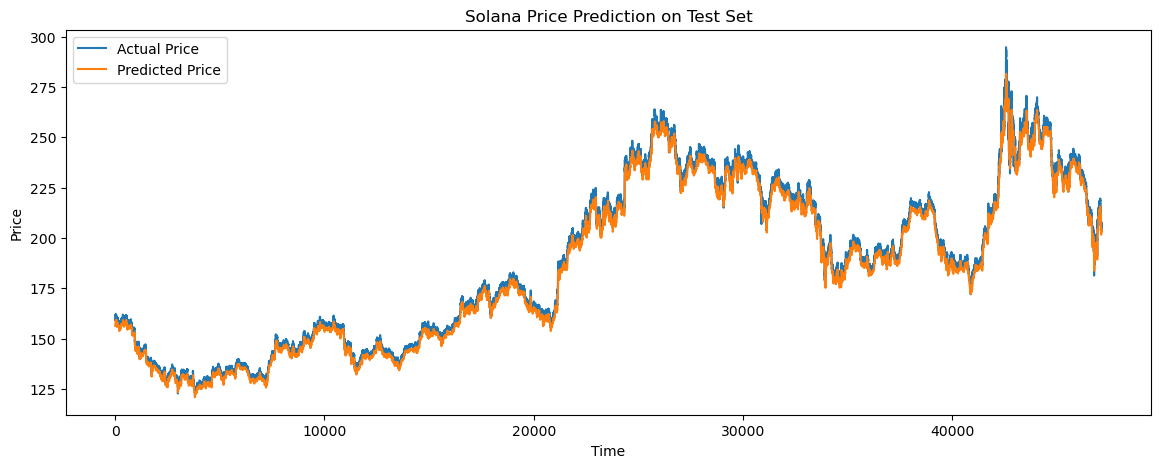

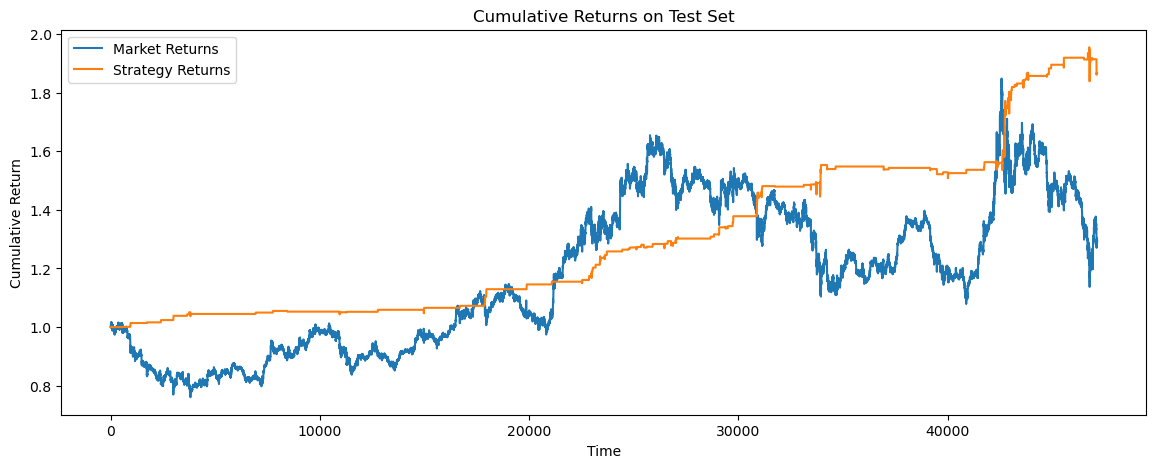

In [10]:
# Plot results
trader.plot_predictions()
trader.plot_cumulative_returns()

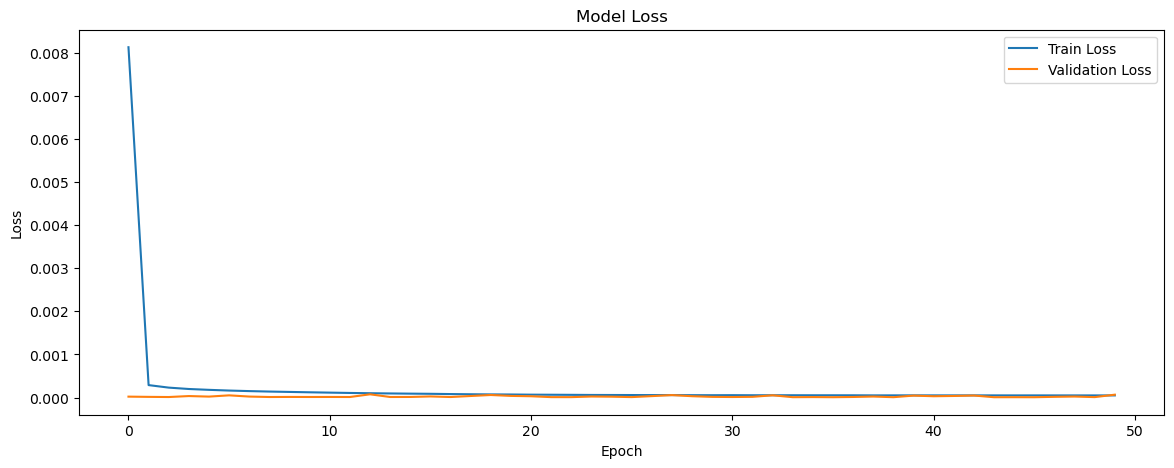

In [11]:
trader.plot_loss()

In [12]:
trader.load_model()

Model built successfully.
Model loaded from solana_only_long.pth.
Scaler loaded from scaler_only_long.pkl.


C:\Users\stoic\AppData\Local\Temp\ipykernel_556\4227416297.py:323: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


In [13]:
# Evaluate the model
trader.evaluate_model(batch_size=512)

MSE: 446976.875
RMSE: 668.5632934570312
MAE: 622.1171264648438


In [14]:
# Backtest the trading strategy
trader.backtest_strategy()

Cumulative Market Return: 29.48%
Cumulative Strategy Return: 86.97%
